# all_sky_vignetting
<pre>
This the first step for all-sky calibration.
Contribution to 
Jia Yin et al. MNRAS 537,617-627 (2025)
"Calibration and applications of the all-sky camera at the Ali Observatory in Tibet"
National Astronomical Observatories, Chinese Academy of Sciences

Testing in 
## Pic du Midi Observatory (France), Canon EOS6D + Sigma 8mm f/3.5,  Rémi Boucher 
ifile = '_MG_3294.CR2' 
tz = ZoneInfo('Europe/Paris')
location = ['Pic du Midi Observatory', 0.14, 42.94, 2877] #[longitude.deg, latitude.deg, height.m]

This procedure applies a FLAT to correct vignetting of Sigma 8mm on Canon EOS5D Mark II
The flat was created using a model built with coefficients from lensfun database

INPUT : RAW  Canon CR2 file  and  Flat image
OUTPUT: RGB fits files and RGB corrected fits files
</pre>


In [1]:
import numpy as np 
import os
from astropy.io import fits
#import healpy as hp
#from scipy.interpolate import RegularGridInterpolator, griddata
#from healpy.projector import GnomonicProj
import datetime
from datetime import datetime
from zoneinfo import ZoneInfo
from astropy.time import Time
#from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u
#import matplotlib.image as mpig
#from gwcs.wcstools import wcs_from_points
#from astropy.modeling.projections import Sky2Pix_ZEA
#import asdf 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

#from matplotlib.patches import Ellipse

#import lmfit
#import cv2
import rawpy
#from astropy.table import Table,vstack,hstack,QTable

#import photutils
#from photutils import aperture
#from photutils.aperture import CircularAperture
#from photutils.aperture import CircularAnnulus
#from photutils.aperture import aperture_photometry

#import sep

### Functions

In [2]:
# convert the cr2 file to R G B    azotea method
def bayer_from_exif(img):
    BAYER_LETTER = ['B4','G2','R1','G3']
    color_desc = img.color_desc.decode()
    if color_desc != 'RGBG':
        raise ValueError(f"{color_desc} Color Filter Array not supported")
    print(img.raw_pattern)
    bayer_pattern = ''.join([ BAYER_LETTER[img.raw_pattern[row,column]] for row in (0,1) for column in (0,1)])
    return bayer_pattern

def cr2_extract(filename):
    img = rawpy.imread(filename)
    print('image RGB ful matrix',img.raw_image.shape)
    print('image RGB visible   ',img.raw_image_visible.shape)
    R1 = img.raw_image_visible[::2,::2]
    G2 = img.raw_image_visible[::2,1::2]
    G3 = img.raw_image_visible[1::2,::2]
    B4 = img.raw_image_visible[1::2,1::2]
    return R1,G2,G3,B4

### Reading the FLAT

In [3]:
flatfile = 'flat-sigma-8-f35_EOS6DMII.fits'
header = fits.getheader(flatfile)
flat_data   = fits.getdata(flatfile)
print(header)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 3132                                                  NAXIS2  =                 2090                                                  EXTEND  =                    T                                                  FILENAME= 'flat-sigma-8-f35_EOS6DMII.fits'                                      HISTORY --------------------                                                    HISTORY 2025-05-10 10:20:25                                                     HISTORY using data from lensfun                                                 HISTORY ref. image: IMG_9467.CR2                                                END                                                                                                                     

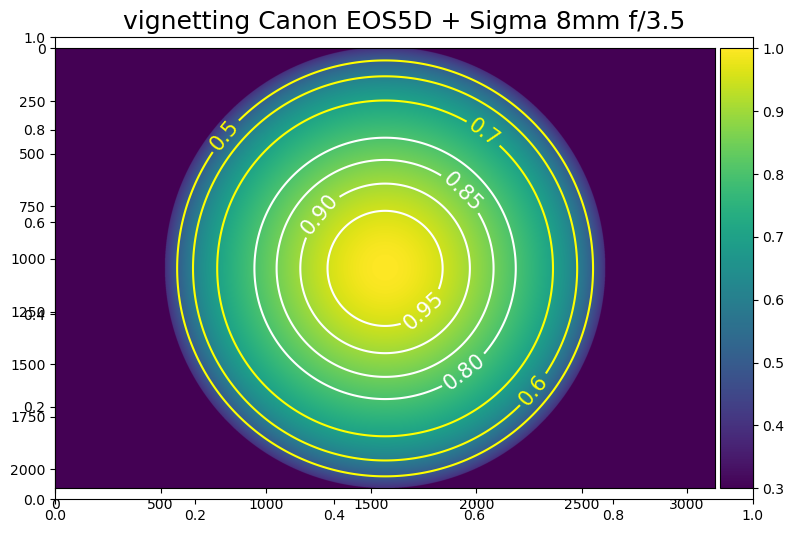

In [4]:
figura=plt.figure(figsize=(9,6))
plt.title('vignetting Canon EOS5D + Sigma 8mm f/3.5',fontsize=18)
ax=figura.add_subplot(111)
img = plt.imshow(flat_data,vmin=0.3,vmax=1.0)

levels = np.arange(0.8,1.02,0.05)
cs = plt.contour(flat_data,levels,colors='white')
ax.clabel(cs,levels,inline=True,fontsize=15)
levels = np.arange(0.5,0.75,0.1)
cs = plt.contour(flat_data,levels,colors='yellow')
ax.clabel(cs,levels,inline=True,fontsize=15)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
figura.colorbar(img, cax=cax)

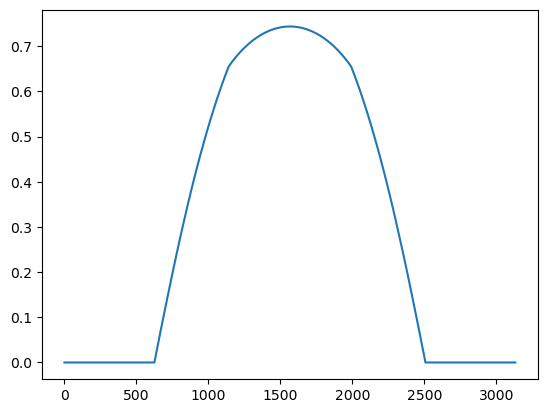

In [5]:
plt.plot(flat_data[1500:2000,:].mean(axis=0))

#### Picture to correct 

In [6]:
## Pic du Midi Observatory (France), Canon EOS6D + Sigma 8mm f/3.5,  Rémi Boucher 
ifile = 'IMG_9467.CR2' 
ifile = 'IMG_9442.CR2' 

In [7]:
# Jaime links
ex_path = '' # exiftool path
ipath   = './'

In [8]:
# EXIF metadata information

tags = '-MeasuredEV -LightValue -ISO -ExposureTime -Aperture -BlueBalance ' \
        +'-RedBalance -PerChannelBlackLevel -Lens -CanonImageType -CR2CFAPattern ' \
        +'-CreateDate -Orientation -SensorWidth -SensorHeight -RawMeasuredRGGB ' \
        +'-XResolution -YResolution -ExifVersion -ExposureProgram -Flash -FocusMode ' \
        +'-LensType -ControlMode -RawJpgSize -ColorTemperature -PictureStyle ' \
        +'-SensorLeftBorder -SensorTopBorder -SensorRightBorder -SensorBottomBorder -ModifyDate '
vtags = os.popen(ex_path+'exiftool -f -T '+tags +ipath+ifile).read()
vars = vtags.split('\t')
vars[-1] = vars[-1].split('\n')[0]
print(vars)
print('RGB Bayer matrix',vars[10])
print('datetime',vars[31])

['-0.62', '-7.3', '1600', '120.2', '3.5', '2.333008', '1.774414', '2048 2048 2048 2048', '8.0 mm', 'Canon EOS 6D Mark II', '[Red,Green][Green,Blue]', '2023:10:11 16:31:51', 'Rotate 90 CW', '6384', '4224', '-', '72', '72', '0230', 'Bulb', 'Off, Did not fire', 'Manual Focus (3)', 'Canon EF 28-80mm f/2.8-4L USM or Sigma Lens', 'Camera Local Control', 'Large', '5200', 'Auto', '132', '56', '6371', '4215', '2023:10:11 16:31:51']
RGB Bayer matrix [Red,Green][Green,Blue]
datetime 2023:10:11 16:31:51


#### Spliting the RAW picture to RGB images

In [9]:
# How the Bayer matrix is organized
bayer_pattern = bayer_from_exif(rawpy.imread(ipath+ifile))
print(bayer_pattern)
print(vars[10])

R1,G2,G3,B4 = cr2_extract(ipath+ifile)
raw_g = G2 * 1.0

[[0 1]
 [3 2]]
B4G2G3R1
[Red,Green][Green,Blue]
image RGB ful matrix (4224, 6384)
image RGB visible    (4180, 6264)


2319.649327974237


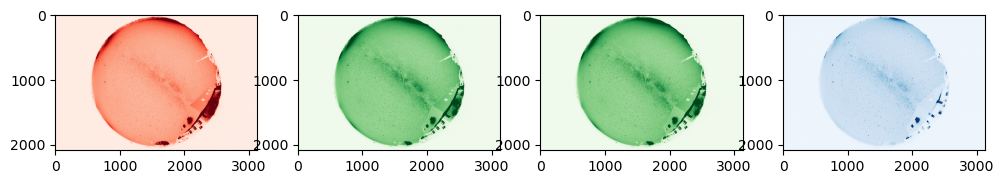

In [10]:
vmin, vmax = 2000, 3000
fig,ax = plt.subplots(1,4,figsize=(12,6))
ax[0].imshow(R1,cmap='Reds',vmin=vmin,vmax=vmax)
ax[1].imshow(G2,cmap='Greens',vmin=vmin,vmax=vmax)
ax[2].imshow(G2,cmap='Greens',vmin=vmin,vmax=vmax)
im = ax[3].imshow(B4,cmap='Blues',vmin=vmin,vmax=vmax)
#plt.colorbar(im)
print(np.mean(G2))

#### FLAT correction

In [11]:
def create_circular_mask(h, w, center=None, radius=None):
# https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [12]:
h, w = G2.shape[:2]
radius = h/2
mask = create_circular_mask(h, w, radius = radius)

In [13]:
# Corrigiendo de FLAT lensfun
BIAS = 2048  # from EXIF

masked_R1 = R1 - BIAS
masked_R1[~mask] = 0
R1_corr = masked_R1 / flat_data
R1_corr[~mask] = 0

masked_G2 = G2 - BIAS
masked_G2[~mask] = 0
G2_corr = masked_G2 / flat_data
G2_corr[~mask] = 0

masked_G3 = G3 - BIAS
masked_G3[~mask] = 0
G3_corr = masked_G3 / flat_data
G3_corr[~mask] = 0

masked_B4 = B4 - BIAS
masked_B4[~mask] = 0
B4_corr = masked_B4 / flat_data
B4_corr[~mask] = 0


/var/folders/2y/m_zlcv4x1ml0b6cm5_4f42y40000gn/T/ipykernel_38831/4262380595.py:6: RuntimeWarning: invalid value encountered in divide
  R1_corr = masked_R1 / flat_data
/var/folders/2y/m_zlcv4x1ml0b6cm5_4f42y40000gn/T/ipykernel_38831/4262380595.py:11: RuntimeWarning: invalid value encountered in divide
  G2_corr = masked_G2 / flat_data
/var/folders/2y/m_zlcv4x1ml0b6cm5_4f42y40000gn/T/ipykernel_38831/4262380595.py:16: RuntimeWarning: invalid value encountered in divide
  G3_corr = masked_G3 / flat_data
/var/folders/2y/m_zlcv4x1ml0b6cm5_4f42y40000gn/T/ipykernel_38831/4262380595.py:21: RuntimeWarning: invalid value encountered in divide
  B4_corr = masked_B4 / flat_data


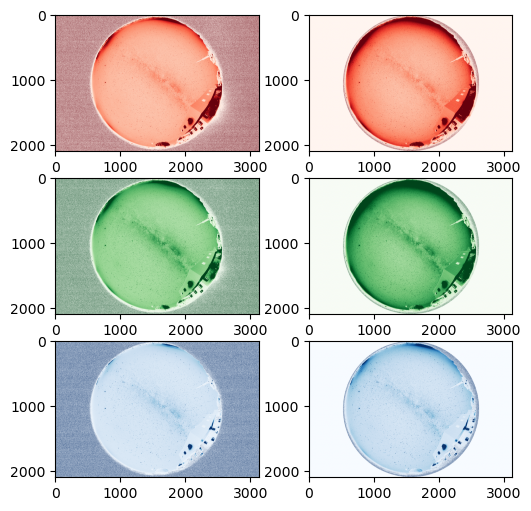

In [14]:
vmax = 1000
fig,ax = plt.subplots(3,2,figsize=(6,6))
ax[0,0].imshow(R1-BIAS,cmap='Reds',vmin=0,vmax=vmax)
ax[1,0].imshow(G2-BIAS,cmap='Greens',vmin=0,vmax=vmax)
ax[2,0].imshow(B4-BIAS,cmap='Blues',vmin=0,vmax=vmax)

ax[0,1].imshow(R1_corr,cmap='Reds',vmin=0,vmax=vmax)
ax[1,1].imshow(G2_corr,cmap='Greens',vmin=0,vmax=vmax)
ax[2,1].imshow(B4_corr,cmap='Blues',vmin=0,vmax=vmax)

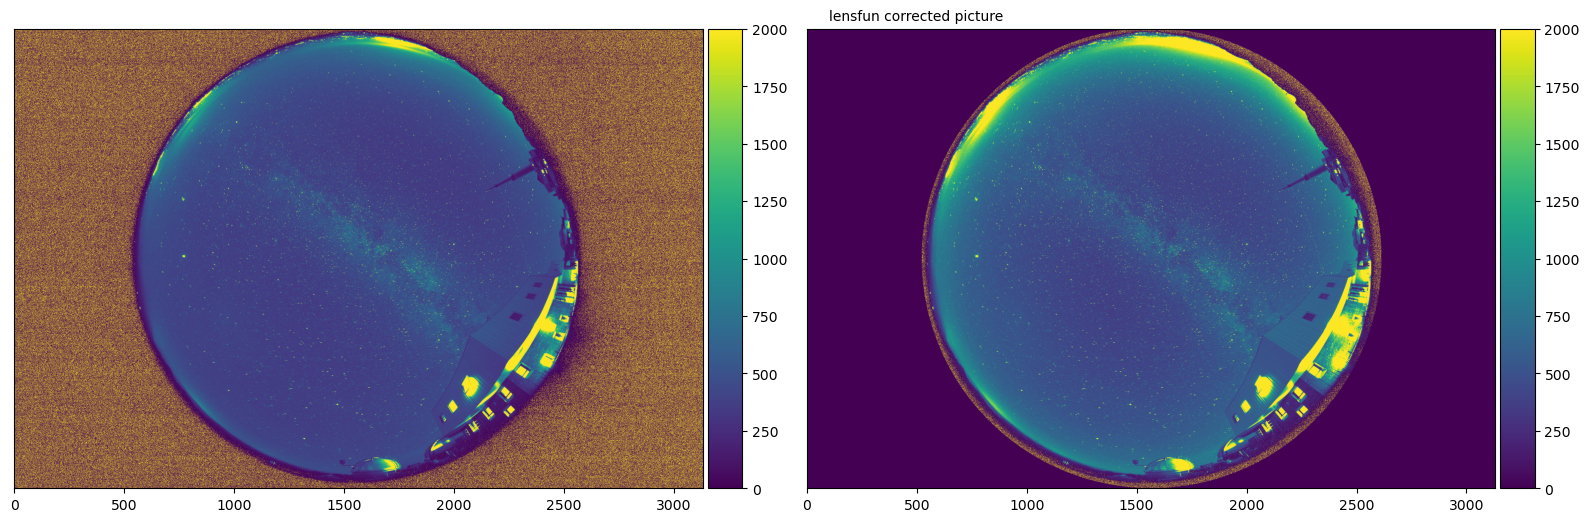

In [15]:
vmin = 0 
vmax = 2000

figura=plt.figure(figsize=(16,6))
ax=figura.add_subplot(121)
#ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
img = plt.imshow(G2-BIAS,vmin=vmin,vmax=vmax)
#plt.suptitle('Canon EOS5D + Sigma 8mm f/3.5')
plt.text(100,-40,'Original picture',color="white")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
figura.colorbar(img, cax=cax)

ax=figura.add_subplot(122)
#ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
img = plt.imshow(G2_corr,vmin=vmin,vmax=vmax)
plt.text(100,-40,'lensfun corrected picture',color="black")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
figura.colorbar(img, cax=cax)

plt.tight_layout()


#### Writing the R G B images to FITS

In [16]:
# R1 channel
output_filename = ifile.replace('.CR2','_R1.fits')
print(f'Saving file: {output_filename}')
hdu = fits.PrimaryHDU(R1)
hdu.header['FILENAME'] = output_filename
hdu.header['HISTORY']  = '-------------------- '
hdu.header['HISTORY']  = f'{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}'
hdu.header['HISTORY']  = 'R1 channel'
hdu.writeto(output_filename, overwrite='yes')

# G2 channel
output_filename = ifile.replace('.CR2','_G2.fits')
print(f'Saving file: {output_filename}')
hdu = fits.PrimaryHDU(G2)
hdu.header['FILENAME'] = output_filename
hdu.header['HISTORY']  = '-------------------- '
hdu.header['HISTORY']  = f'{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}'
hdu.header['HISTORY']  = 'G2 channel'
hdu.writeto(output_filename, overwrite='yes')

# G3 channel
output_filename = ifile.replace('.CR2','_G3.fits')
print(f'Saving file: {output_filename}')
hdu = fits.PrimaryHDU(G3)
hdu.header['FILENAME'] = output_filename
hdu.header['HISTORY']  = '-------------------- '
hdu.header['HISTORY']  = f'{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}'
hdu.header['HISTORY']  = 'G2 channel'
hdu.writeto(output_filename, overwrite='yes')

# B4 channel
output_filename = ifile.replace('.CR2','_B4.fits')
print(f'Saving file: {output_filename}')
hdu = fits.PrimaryHDU(B4)
hdu.header['FILENAME'] = output_filename
hdu.header['HISTORY']  = '-------------------- '
hdu.header['HISTORY']  = f'{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}'
hdu.header['HISTORY']  = 'B channel'
hdu.writeto(output_filename, overwrite='yes')


Saving file: IMG_9442_R1.fits
Saving file: IMG_9442_G2.fits
Saving file: IMG_9442_G3.fits
Saving file: IMG_9442_B4.fits


#### Writing the corrected R G B images to FITS 

In [17]:
ifile.replace('.CR2','_R_corr.fits')
flatfile

'flat-sigma-8-f35_EOS6DMII.fits'

In [18]:
# R channel
output_filename = ifile.replace('.CR2','_R1_corr.fits')
print(f'Saving file: {output_filename}')
hdu = fits.PrimaryHDU(R1_corr)

hdu.header['FILENAME'] = output_filename
hdu.header['HISTORY']  = '-------------------- '
hdu.header['HISTORY']  = f'{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}'
hdu.header['HISTORY']  = 'Corrected from vignetting using ' + flatfile
hdu.header['HISTORY']  = 'R1 channel'

hdu.writeto(output_filename, overwrite='yes')

Saving file: IMG_9442_R1_corr.fits


In [19]:
# G2 channel
output_filename = ifile.replace('.CR2','_G2_corr.fits')
print(f'Saving file: {output_filename}')
hdu = fits.PrimaryHDU(G2_corr)

hdu.header['FILENAME'] = output_filename
hdu.header['HISTORY']  = '-------------------- '
hdu.header['HISTORY']  = f'{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}'
hdu.header['HISTORY']  = 'Corrected from vignetting using ' + flatfile
hdu.header['HISTORY']  = 'G2 channel'

hdu.writeto(output_filename, overwrite='yes')

# G3 channel
output_filename = ifile.replace('.CR2','_G3_corr.fits')
print(f'Saving file: {output_filename}')
hdu = fits.PrimaryHDU(G3_corr)

hdu.header['FILENAME'] = output_filename
hdu.header['HISTORY']  = '-------------------- '
hdu.header['HISTORY']  = f'{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}'
hdu.header['HISTORY']  = 'Corrected from vignetting using ' + flatfile
hdu.header['HISTORY']  = 'G3 channel'

hdu.writeto(output_filename, overwrite='yes')

Saving file: IMG_9442_G2_corr.fits
Saving file: IMG_9442_G3_corr.fits


In [20]:
# B4 channel
output_filename = ifile.replace('.CR2','_B4_corr.fits')
print(f'Saving file: {output_filename}')
hdu = fits.PrimaryHDU(B4_corr)

hdu.header['FILENAME'] = output_filename
hdu.header['HISTORY']  = '-------------------- '
hdu.header['HISTORY']  = f'{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}'
hdu.header['HISTORY']  = 'Corrected from vignetting using ' + flatfile
hdu.header['HISTORY']  = 'B4 channel'

hdu.writeto(output_filename, overwrite='yes')

Saving file: IMG_9442_B4_corr.fits
